## \* Setup steps

In [36]:
!pip install -q -U pydata-google-auth google-cloud-bigquery pyarrow

In [1]:
%load_ext google.cloud.bigquery

In [27]:
import pandas as pd
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format = 'svg'

# Modify this line to your worker project ID
PROJECT_ID = "mlforhc2019-worker-test01"

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

import os
hostname = os.popen('hostname').read().strip()

In [44]:
### DO NOT USE!
# Instead of using service account, to authenticate as user's account:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

from google.cloud.bigquery import magics
magics.context.credentials = credentials
client = bigquery.Client(project=PROJECT_ID, credentials=credentials)

# Example Study: Cohort of Patients with Diabetes

In this sample notebook, we will extract data related to our cohort of interest (patients with diabetes) from the MGI database. 

We will use the following pragmatic definition of diabetes, modified from [Narges Razavian et al., 2015](https://doi.org/10.1089/big.2015.0020). A patient is considered to have diabetes if **any** of the following occurs:

1. a diagnosis code related to Diabetes under the Elixhauser comorbidity index; or
2. use of a diabetes medication, i.e. with a therapeutic class of "antihyperglycemics"; or
3. HbA1C value ≥6.5%. 

The onset time of diabetes for a patient is defined as the earliest time that any of the criteria above are met. 

In [7]:
%%bigquery df_cohort --project $PROJECT_ID
with elixhauserPatients as
(
  select 
    Diag.PatientID,
    min(coalesce(Diag.DiagnosisObservationDate,Diag.ActivityDate)) as `dbDate`
  FROM 
  `mlforhc2019-data-ee97.mlforhc2019_data_data_bq.ComorbidityAlgorithmCodes` CAC
  join
  `mlforhc2019-data-ee97.mlforhc2019_data_data_bq.Diagnoses` Diag on CAC.Lexicon = Diag.Lexicon and CAC.DiagnosisCode  = Diag.TermCodeMapped 
  where
    lower(CAC.Comorbidity)  like '%diabetes%'
    and
    lower(CAC.Algorithm ) like '%elix%'
  Group by
    Diag.PatientID
),
labPatients as
(
  SELECT 
    LR.PatientID,
    min(LR.Observation_Date) as `dbDate`
  FROM `mlforhc2019-data-ee97.mlforhc2019_data_data_bq.LabResults` LR 
  WHERE 
    LOWER(result_name) like '%a1c%' 
    and SAFE_CAST(Value as FLOAT64) > 6.5
  GROUP BY
    LR.PatientID
),
medPatients as
(
  SELECT
    MO.PatientID,
    min(MO.OrderDate) as `dbDate`
  FROM `mlforhc2019-data-ee97.mlforhc2019_data_data_bq.MedicationOrders` MO  
  WHERE
    upper(MO.TherapeuticClass) like '%ANTIHYPERGLYCEMICS%' 
  GROUP BY
    MO.PatientID
),
allPatients as
(
  SELECT *
  FROM elixhauserPatients ep
  
  UNION ALL
  
  SELECT * 
  FROM labPatients lp
  
  UNION ALL
  
  SELECT *
  FROM medPatients mp
)

select
  PatientID,
  min(dbDate) as `earliestDate`
FROM
  allPatients 
GROUP BY
  PatientID

In [ ]:
df_cohort

In [10]:
IDs = df_cohort['PatientID']

## 2. Demographics

Distributions of gender and age

In [9]:
%%bigquery df_patients --project $PROJECT_ID
SELECT * FROM `mlforhc2019-data-ee97`.mlforhc2019_data_data_bq.PatientInfo

In [11]:
df_p = df_patients
df_pop = df_p[df_p['PatientID'].isin(IDs)]

### Gender distribution

In [12]:
df_pop.groupby('GenderName')[['PatientID']].count()

,PatientID
GenderName,
Female,8881
Male,9282


### Age distribution

In [13]:
%%bigquery df_age --project $PROJECT_ID
SELECT PatientID, MAX(AgeInYears) AS Age # Get age at most recent encounter
FROM `mlforhc2019-data-ee97`.mlforhc2019_data_data_bq.Encounter 
GROUP BY PatientID

In [14]:
df_pop_age = df_age[df_age['PatientID'].isin(IDs)].copy()
df_pop_age.describe()

,Age
count,18163.000000
mean,62.495568
std,25.220639
min,18.000000
25%,52.000000
50%,63.000000
75%,71.000000
max,300.000000


In [15]:
# Replace redacted ages (>89) with 90
df_pop_age.loc[df_pop_age['Age'] == 300, 'Age'] = 90

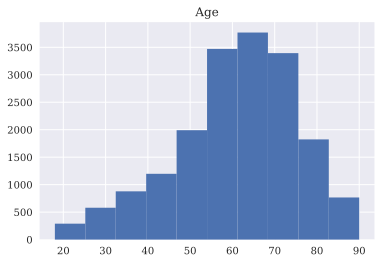

In [16]:
df_pop_age.hist()
plt.show()

## 3. Retrive additional data and save as tables

### 3.0 Create your own dataset

In [33]:
dataset_id = "DiabetesCohort" + '_' + hostname
dataset = bigquery.Dataset("{}.{}".format(client.project, dataset_id))
dataset.location = "US"
try:
    client.get_dataset(dataset)
    print('dataset {}.{} exists'.format(client.project, dataset.dataset_id))
except:
    dataset = client.create_dataset(dataset)
    print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

dataset mlforhc2019-worker-test01.DiabetesCohort_30f6b561ab74 exists


### 3.1 Save the cohort of interest

In [37]:
# Upload a pandas dataframe into your BigQuery dataset
job = client.load_table_from_dataframe(df_cohort, dataset.table('Patients'), location="US")
job.result()  # Waits for table load to complete.
assert job.state == "DONE"

### 3.2 Vital signs

In [50]:
# Save the query results to a BigQuery table in your BigQuery dataset directly
# Without downloading and uploading

# Delete table if exists
client.delete_table(dataset.table('VitalSigns'), not_found_ok=True)

# Run query
q = """
SELECT SV.PatientID,
  SV.EncounterID,
  SV.ObservationDateTime,
  SV.BPDiaInvasive,
  SV.BPSysInvasive,
  SV.BPDiaNonInvasive,
  SV.BPSysNonInvasive,
  SV.HeartRate
FROM 
  `mlforhc2019-worker-test01.{}.Patients` P
join
  `mlforhc2019-data-ee97.mlforhc2019_data_data_bq.NursingStandardVitalSigns` SV on P.PatientID = SV.PatientID
where
  SV.BPDiaInvasive is not null
  or SV.BPSysInvasive is not null
  or SV.BPDiaNonInvasive is not null
  or SV.BPSysNonInvasive is not null
  or SV.HeartRate is not null
""".format(dataset.dataset_id)
job_config = bigquery.QueryJobConfig()
job_config.destination = dataset.table('VitalSigns') # Set destination table
job = client.query(q, job_config=job_config)

# Waits for the query to finish
job.result()
print('Query results loaded to table')

Query results loaded to table


### Lab results

In [49]:
# Save the query results to a BigQuery table in your BigQuery dataset directly
# Without downloading and uploading

# Delete table if exists
client.delete_table(dataset.table('Labs'), not_found_ok=True)

# Run query
q = """
SELECT 
  LR.PatientID ,
  LR.EncounterID,
  LR.Order_Date ,
  LR.Order_Code ,
  LR.Order_Name ,
  LR.Collection_Date ,
  LR.Observation_Date ,
  LR.Result_Code ,
  LR.Result_Name ,
  LR.LOINC,
  LR.Value,
  SAFE_CAST(LR.Value as FLOAT64) as `Value_Numeric`,
  LR.UNit,
  LR.Range
FROM 
  `{}.{}.Patients` P
  join
  `mlforhc2019-data-ee97.mlforhc2019_data_data_bq.LabResults` LR on P.PatientID = LR.PatientID
WHERE
  Value is not null
""".format(PROJECT_ID, dataset.dataset_id)
job_config = bigquery.QueryJobConfig()
job_config.destination = dataset.table('Labs') # Set destination table
job = client.query(q, job_config=job_config)

# Waits for the query to finish
job.result()
print('Query results loaded to table')

Query results loaded to table


### 3.3 Medication Administrations

In [51]:
# Save the query results to a BigQuery table in your BigQuery dataset directly
# Without downloading and uploading

# Delete table if exists
client.delete_table(dataset.table('Meds'), not_found_ok=True)

# Run query
q = """
SELECT
  MA.*
FROM
  `{}.{}.Patients` P
JOIN
  `mlforhc2019-data-ee97.mlforhc2019_data_data_bq.MedicationAdministrations` MA
ON
  P.PatientID = MA.PatientID
""".format(PROJECT_ID, dataset.dataset_id)
job_config = bigquery.QueryJobConfig()
job_config.destination = dataset.table('Meds') # Set destination table
job = client.query(q, job_config=job_config)

# Waits for the query to finish
job.result()
print('Query results loaded to table')

Query results loaded to table


### 3.4 Encounter location type counts

In [52]:
# Save the query results to a BigQuery table in your BigQuery dataset directly
# Without downloading and uploading

# Delete table if exists
client.delete_table(dataset.table('LocationCounts'), not_found_ok=True)

# Run query
q = """
SELECT 
  P.PatientID,
  L.LocationTag,
  count(distinct E.EncounterID) as `numEncounters`
FROM 
  `{}.{}.Patients` P
  join
  `mlforhc2019-data-ee97.mlforhc2019_data_data_bq.Encounter` E on P.PatientID = E.PatientID
  join
  `mlforhc2019-data-ee97.mlforhc2019_data_data_bq.EncounterLocations` EL on E.EncounterID = EL.EncounterID
  join
  `mlforhc2019-data-ee97.mlforhc2019_data_data_bq.LocationTags` L on EL.LocationID = L.LocationID
GROUP BY
  P.PatientID,
  L.LocationTag
""".format(PROJECT_ID, dataset.dataset_id)
job_config = bigquery.QueryJobConfig()
job_config.destination = dataset.table('LocationCounts') # Set destination table
job = client.query(q, job_config=job_config)

# Waits for the query to finish
job.result()
print('Query results loaded to table')

Query results loaded to table


### 3.5 Height, Weight, Body-mass index (BMI)

In [56]:
# Save the query results to a BigQuery table in your BigQuery dataset directly
# Without downloading and uploading

# Delete table if exists
client.delete_table(dataset.table('BMI'), not_found_ok=True)

# Run query
q = """
select
P.PatientID,
B.EncounterID,
B.BMI
from
`{}.{}.Patients` P
join
`mlforhc2019-data-ee97.mlforhc2019_data_data_bq.Encounter` E on P.PatientID = E.PatientID
join
`mlforhc2019-data-ee97.mlforhc2019_data_data_bq.EncounterBmiCombined` B on B.EncounterID  = E.EncounterID 
""".format(PROJECT_ID, dataset.dataset_id)
job_config = bigquery.QueryJobConfig()
job_config.destination = dataset.table('BMI') # Set destination table
job = client.query(q, job_config=job_config)

# Waits for the query to finish
job.result()
print('Query results loaded to table')

Query results loaded to table


### 3.6 Orders related to a dietitian

In [55]:
# Save the query results to a BigQuery table in your BigQuery dataset directly
# Without downloading and uploading

# Delete table if exists
client.delete_table(dataset.table('DietitianOrders'), not_found_ok=True)

# Run query
q = """
select 
  O.*
from
`{}.{}.Patients` P
join
`mlforhc2019-data-ee97.mlforhc2019_data_data_bq.Non_MedicationOrders` O on P.PatientID = O.PatientID 
where
(
  lower(ordername) like '%dietitian%' 
  or lower(ordertype) like '%dietitian%'
)
""".format(PROJECT_ID, dataset.dataset_id)
job_config = bigquery.QueryJobConfig()
job_config.destination = dataset.table('DietitianOrders') # Set destination table
job = client.query(q, job_config=job_config)

# Waits for the query to finish
job.result()
print('Query results loaded to table')

Query results loaded to table
